# Summary

Dans ce notebook, nous allons mettre en pratique les algorithmes de regression sur un jeu de données relatif aux faux billets de banque.

Pour rappel, voici **quelques étapes de travail** d'un **Data Scientist** sont les suivantes:

![image.png](attachment:0e82b165-14b0-416e-8e0b-49bfa12a06fd.png)

In [46]:
from pathlib import Path

import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objs as go
import seaborn as sns
from plotly.subplots import make_subplots
from ydata_profiling import ProfileReport
from yellowbrick.regressor import ResidualsPlot
import matplotlib.pyplot as plt

In [6]:
# Return a new path pointing to the current working directory
HOME_DIR = Path.cwd()

In [8]:
# you must put the CSV file billets.csv in data directory, cf above cell
data = pd.read_csv(Path(HOME_DIR, "billets.csv"), sep=";")
data.shape  # data frame dimensions (nb rows, nb columns)

(1500, 7)

In [10]:
# Return the first `n` rows, default is 5
data.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


In [12]:
# Print a concise summary of a DataFrame
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


In [14]:
# Generate descriptive statistics
data.describe(include="all")

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500,1500.000000,1500.000000,1500.000000,1463.000000,1500.000000,1500.00000
unique,2,NaN,NaN,NaN,NaN,NaN,NaN
top,True,NaN,NaN,NaN,NaN,NaN,NaN
freq,1000,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,171.958440,104.029533,103.920307,4.485967,3.151473,112.67850
std,NaN,0.305195,0.299462,0.325627,0.663813,0.231813,0.87273
min,NaN,171.040000,103.140000,102.820000,2.980000,2.270000,109.49000
25%,NaN,171.750000,103.820000,103.710000,4.015000,2.990000,112.03000
50%,NaN,171.960000,104.040000,103.920000,4.310000,3.140000,112.96000
75%,NaN,172.170000,104.230000,104.150000,4.870000,3.310000,113.34000


In [17]:
# Return a Series containing counts of unique values.

data.is_genuine.value_counts(dropna=False,  # If True, don't include counts of NaN.
                             normalize=False,  # If True then the object returned will contain the relative frequencies of the unique values.
                            )

is_genuine
True     1000
False     500
Name: count, dtype: int64

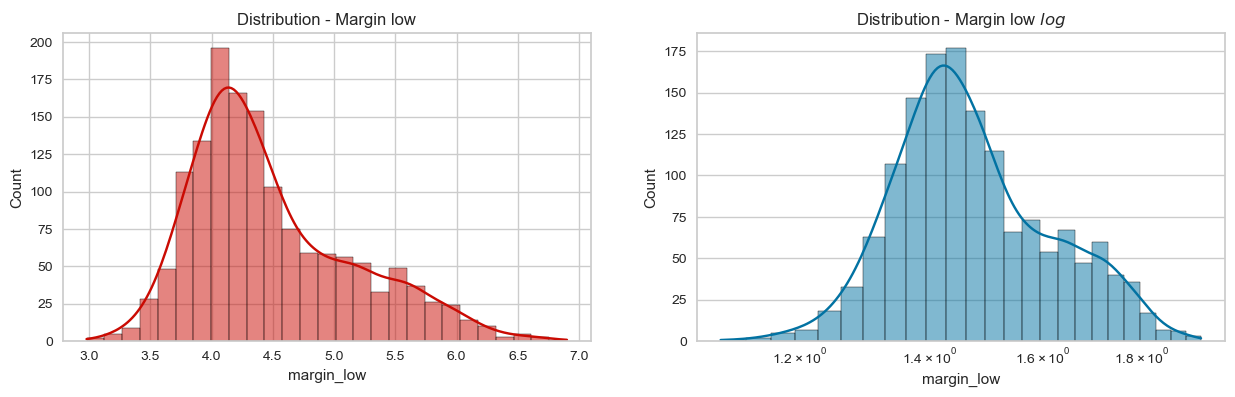

In [19]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))

sns.histplot(data["margin_low"], color='r', kde=True, ax=axes[0])
axes[0].set_title('Distribution - Margin low')

sns.histplot(np.log(data["margin_low"]), color='b', kde=True, ax=axes[1])
axes[1].set_title('Distribution - Margin low $log$')
axes[1].set_xscale('log');

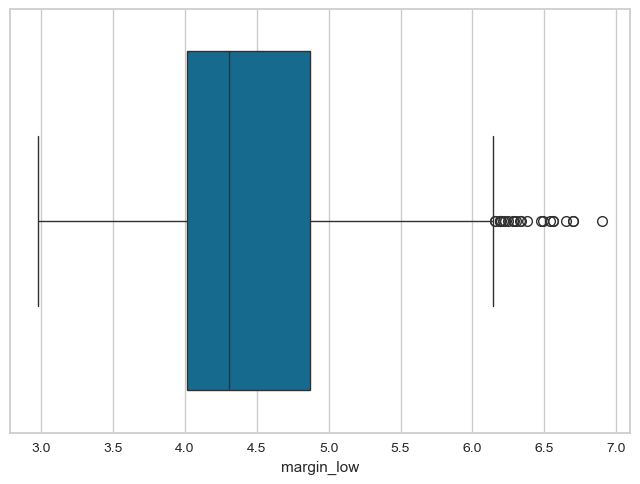

In [21]:
sns.boxplot(data["margin_low"], orient="h");

C:\Users\DELL\AppData\Local\Temp\ipykernel_3696\1948983797.py:7: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes.
  data.boxplot(column=num_columns, by="is_genuine", ax=ax, grid=False,);


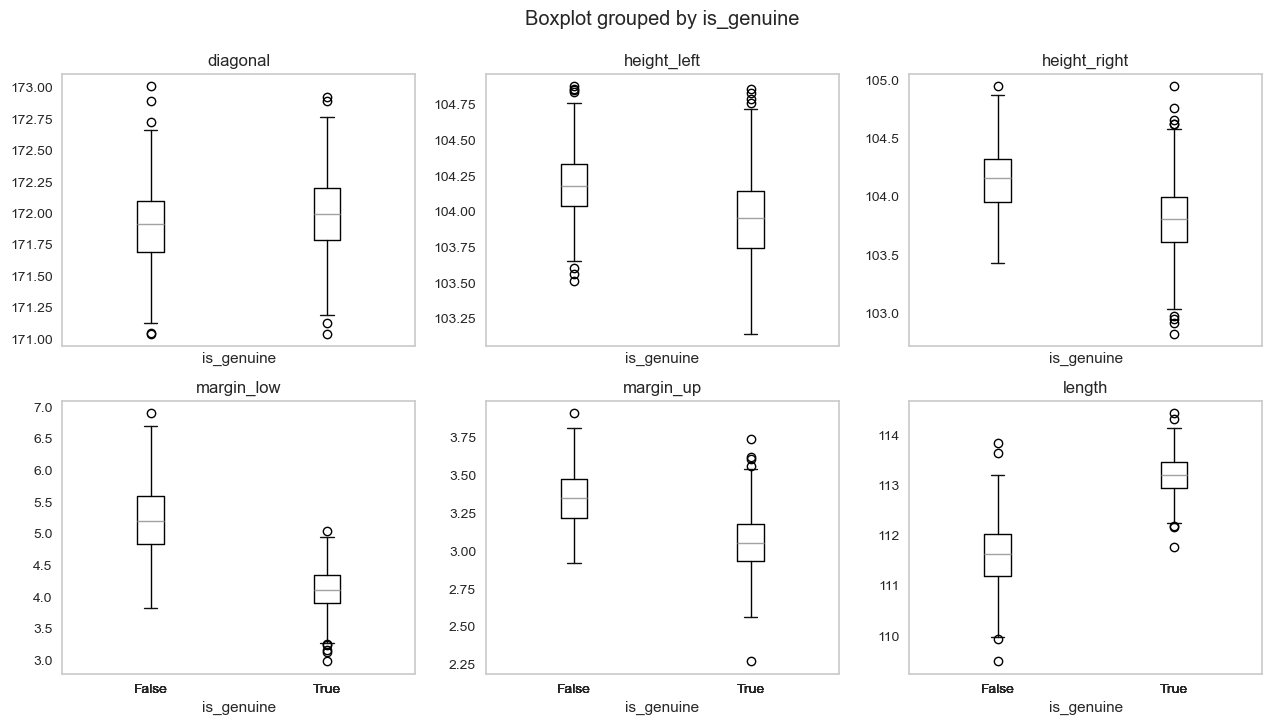

In [25]:
 #distribution en fonction du type de billet (Faux vs Vrai)

num_columns = list(data.select_dtypes(include=[int, float]).columns) # extraction des colonnes numériques/décimales
# définition des caratéritiques de graph
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 8), sharey=False, sharex=True)
# box plot
data.boxplot(column=num_columns, by="is_genuine", ax=ax, grid=False,);

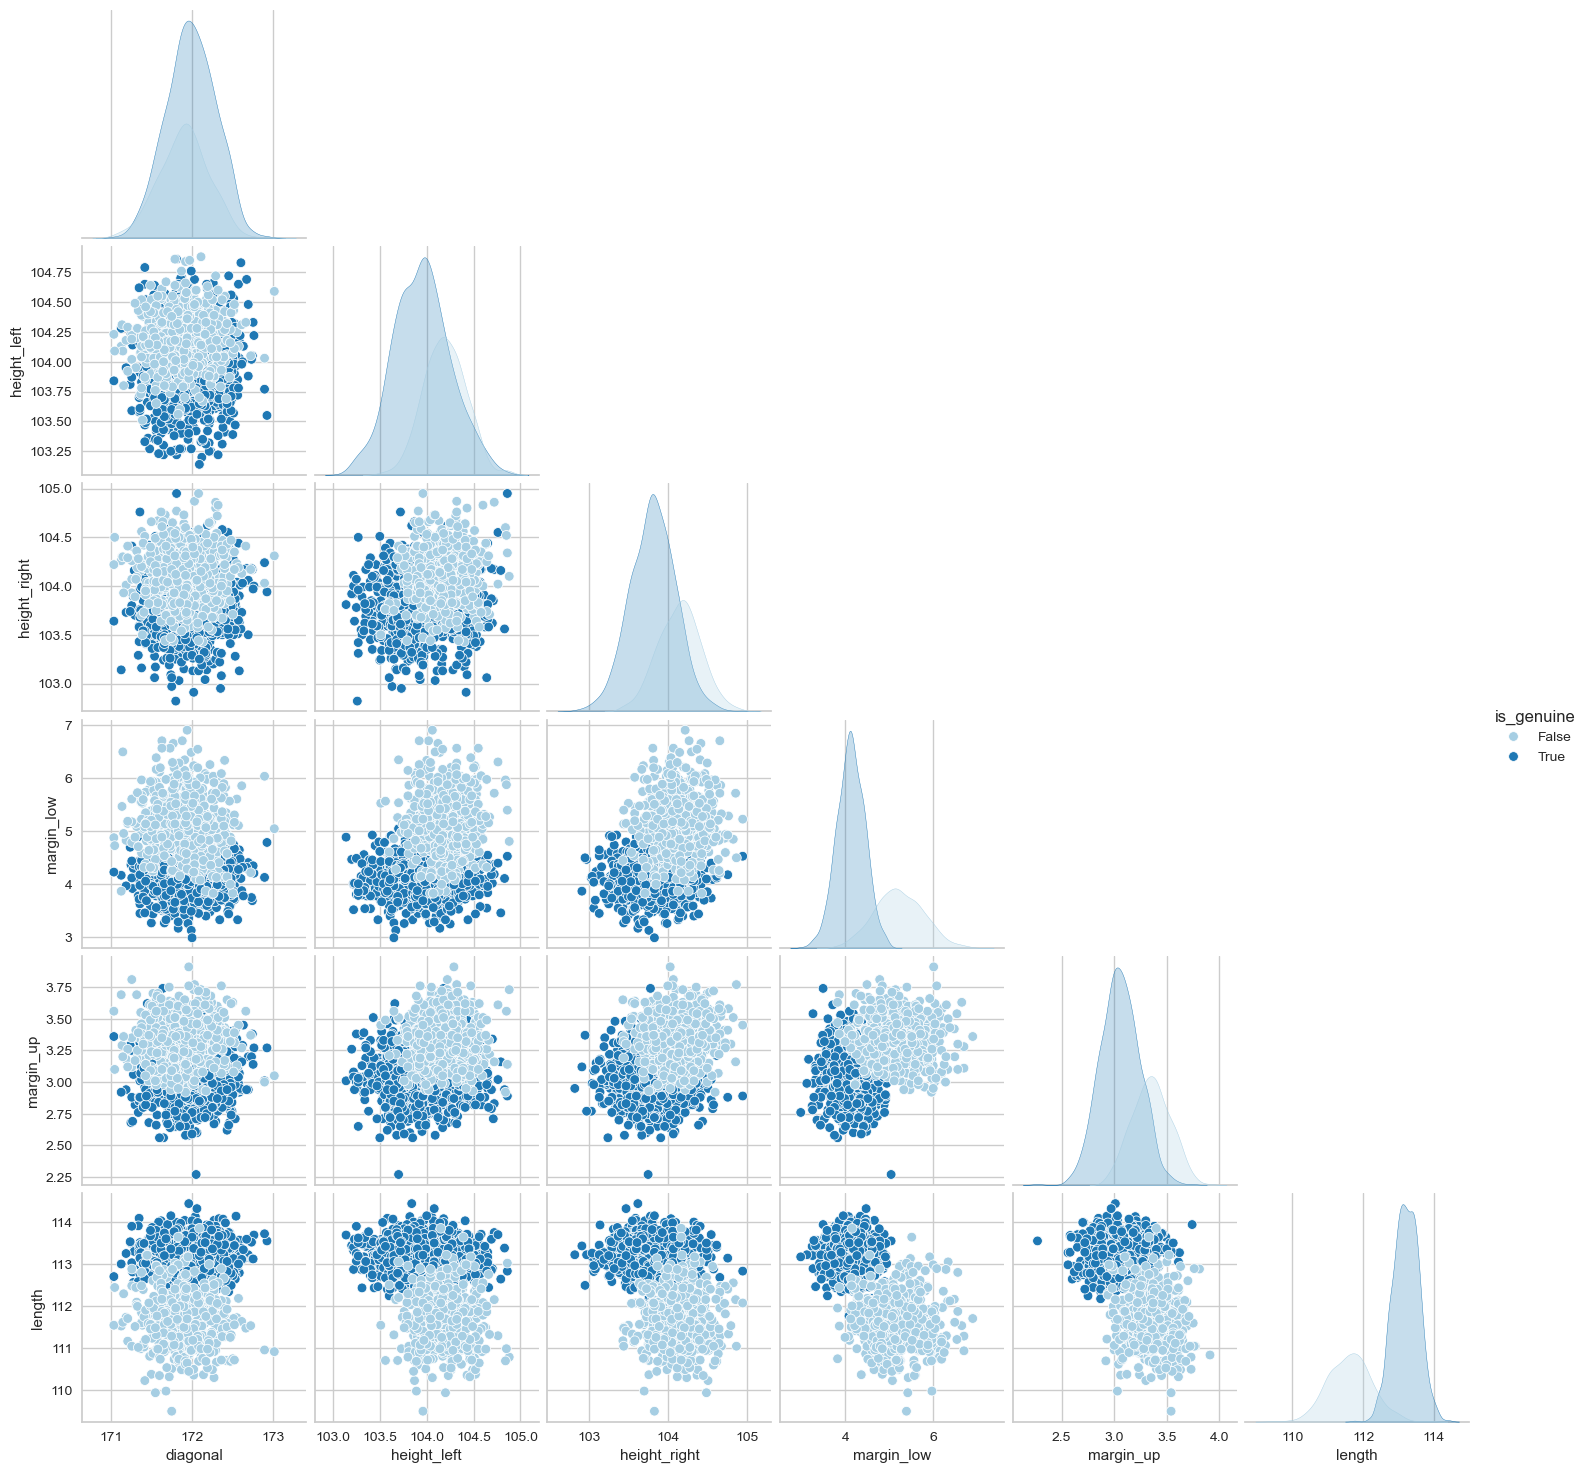

In [27]:
sns.pairplot(data, hue="is_genuine", palette="Paired", corner=True, diag_kind="kde");

# Modeling

In [99]:
from sklearn import linear_model

import statsmodels.formula.api as smf
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from statsmodels.stats.diagnostic import het_white , normal_ad
from sklearn.model_selection import GridSearchCV

In [32]:
data_model = data.loc[lambda dfr: dfr.margin_low.notnull()]

data_model.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1463 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1463 non-null   bool   
 1   diagonal      1463 non-null   float64
 2   height_left   1463 non-null   float64
 3   height_right  1463 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1463 non-null   float64
 6   length        1463 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 81.4 KB


In [34]:
# Création des variables explicatives et cible:
# X est la liste des variables explicatives et y est la variable cible
X = data_model.loc[:, ["diagonal", "height_left", "height_right", "margin_up", "length"]]  # ou data.drop(["margin_low", "is_genuine"], axis=1)
y = data_model.loc[:, 'margin_low']

In [36]:
# Séparons nos données en un jeu d'entraînement et un jeu de test :
# 30% des données dans le jeu de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f"Train set - X: {X_train.shape} ; y: {y_train.shape} \nTest set - X: {X_test.shape} ; y: {y_test.shape}")

Train set - X: (1024, 5) ; y: (1024,) 
Test set - X: (439, 5) ; y: (439,)


In [38]:
# Standardisons les données :

std_scaler = StandardScaler().fit(X_train)  # Standardize features by removing the mean and scaling to unit variance.
X_train_std = std_scaler.transform(X_train)
X_test_std = std_scaler.transform(X_test)

# Exercice 1:
### Dans la cellule précédente, veuillez analyser les variables explicatives: que constatez vous entre le jeu de train et le jeu de test?

### Statistiques descriptives

In [273]:
# Calcul des statistiques descriptives pour les deux data (train and test) et les données principales
train_desc = X_train.describe()
test_desc = X_test.describe()
data_desc = data_model.describe()

# Renommer les colonnes pour différencier les variables des deux data (train and test) 
train_desc.columns = [f'Train_{col}' for col in train_desc.columns]
test_desc.columns = [f'Test_{col}' for col in test_desc.columns]
data_desc.columns = [f'{col}' for col in data_desc.columns]

# tableau récapitulatif des stats desc
data_comparaison = pd.concat([data_desc, train_desc, test_desc], axis=1)

print("Comparaison des statistiques descriptives (Train vs Test) :")
display(data_comparaison)

Comparaison des statistiques descriptives (Train vs Test) :


,diagonal,height_left,height_right,margin_low,margin_up,length,Train_diagonal,Train_height_left,Train_height_right,Train_margin_up,Train_length,Test_diagonal,Test_height_left,Test_height_right,Test_margin_up,Test_length
count,1463.000000,1463.000000,1463.000000,1463.000000,1463.000000,1463.000000,1024.000000,1024.000000,1024.000000,1024.000000,1024.000000,439.000000,439.000000,439.000000,439.000000,439.000000
mean,171.959193,104.031333,103.921476,4.485967,3.153083,112.674757,171.962383,104.035996,103.921045,3.157305,112.675596,171.951754,104.020456,103.922483,3.143235,112.672802
std,0.305457,0.299605,0.324181,0.663813,0.231466,0.873222,0.301231,0.300359,0.326683,0.230871,0.873045,0.315320,0.297897,0.318636,0.232813,0.874626
min,171.040000,103.140000,102.910000,2.980000,2.270000,109.490000,171.050000,103.220000,102.910000,2.560000,109.970000,171.040000,103.140000,103.030000,2.270000,109.490000
25%,171.750000,103.825000,103.710000,4.015000,2.990000,112.020000,171.750000,103.827500,103.700000,2.990000,112.045000,171.745000,103.825000,103.725000,2.980000,111.990000
50%,171.960000,104.040000,103.920000,4.310000,3.140000,112.960000,171.960000,104.040000,103.920000,3.140000,112.950000,171.950000,104.030000,103.920000,3.140000,112.980000
75%,172.170000,104.230000,104.150000,4.870000,3.315000,113.340000,172.180000,104.240000,104.160000,3.310000,113.332500,172.160000,104.230000,104.140000,3.320000,113.350000
max,173.010000,104.880000,104.950000,6.900000,3.910000,114.320000,172.890000,104.880000,104.950000,3.910000,114.320000,173.010000,104.830000,104.950000,3.770000,114.130000


On constate que, pour une même variable explicative, la moyenne est presque la même pour 3 bases de données. Par exemple height_left a une moyenne de 104.031 pour l'ensemble des données, 104.035 pour Train, et 104.020 pour Test. Cela indique une bonne représentativité des données d'entraînement et des données de test par rapport à l'ensemble complet.
De plus, l'écart-type pour les variables est également similaire entre les trois ensembles, ce qui suggère une distribution de données similaires.

### Distribution des variables

C:\Users\DELL\AppData\Local\Temp\ipykernel_3696\4208873884.py:4: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.


C:\Users\DELL\AppData\Local\Temp\ipykernel_3696\4208873884.py:5: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.


C:\Users\DELL\AppData\Local\Temp\ipykernel_3696\4208873884.py:6: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.




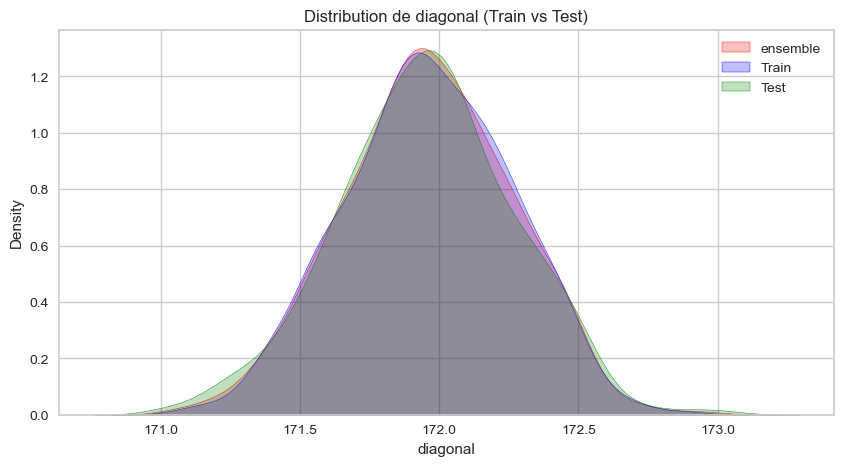

C:\Users\DELL\AppData\Local\Temp\ipykernel_3696\4208873884.py:4: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.


C:\Users\DELL\AppData\Local\Temp\ipykernel_3696\4208873884.py:5: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.


C:\Users\DELL\AppData\Local\Temp\ipykernel_3696\4208873884.py:6: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.




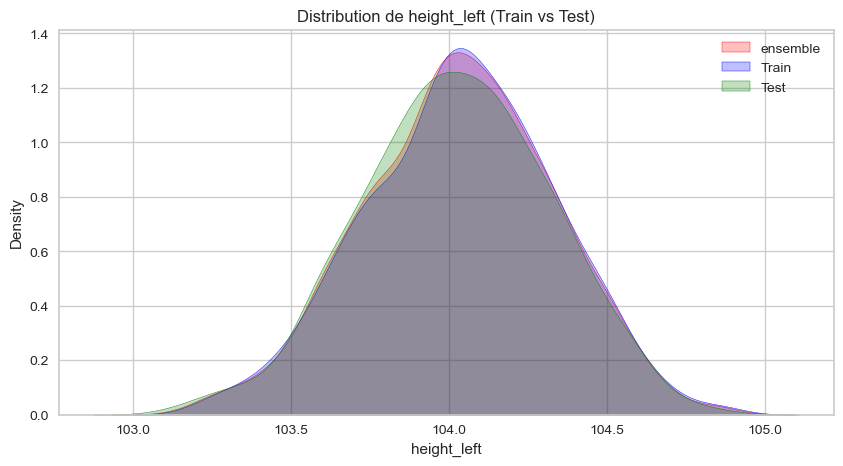

C:\Users\DELL\AppData\Local\Temp\ipykernel_3696\4208873884.py:4: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.


C:\Users\DELL\AppData\Local\Temp\ipykernel_3696\4208873884.py:5: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.


C:\Users\DELL\AppData\Local\Temp\ipykernel_3696\4208873884.py:6: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.




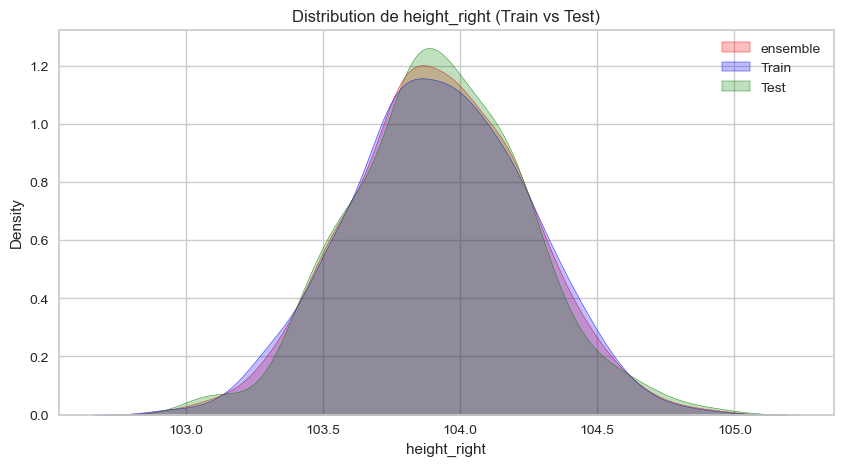

C:\Users\DELL\AppData\Local\Temp\ipykernel_3696\4208873884.py:4: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.


C:\Users\DELL\AppData\Local\Temp\ipykernel_3696\4208873884.py:5: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.


C:\Users\DELL\AppData\Local\Temp\ipykernel_3696\4208873884.py:6: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.




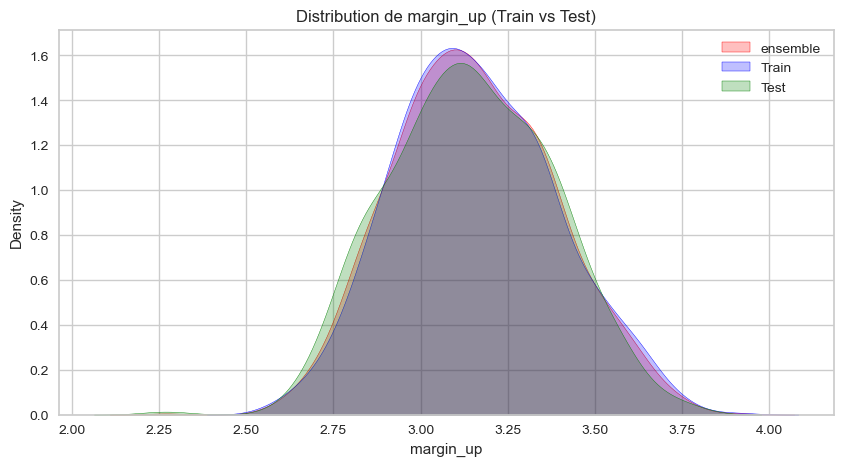

C:\Users\DELL\AppData\Local\Temp\ipykernel_3696\4208873884.py:4: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.


C:\Users\DELL\AppData\Local\Temp\ipykernel_3696\4208873884.py:5: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.


C:\Users\DELL\AppData\Local\Temp\ipykernel_3696\4208873884.py:6: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.




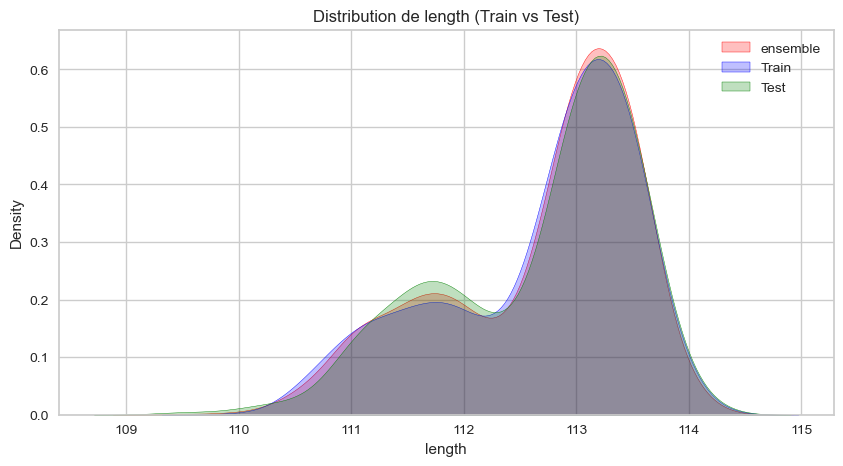

In [294]:
# Tracer les distributions pour chaque variable explicative
for col in X_train.columns:
    plt.figure(figsize=(10, 5))
    sns.kdeplot(data_model[col], label='ensemble', color='red', shade=True)
    sns.kdeplot(X_train[col], label='Train', color='blue', shade=True)
    sns.kdeplot(X_test[col], label='Test', color='green', shade=True)
    plt.title(f'Distribution de {col} (Train vs Test)')
    plt.xlabel(col)
    plt.ylabel('Density')
    plt.legend()
    plt.show()

La distribution est quasi-identique dans tous les ensembles de jeux de données. Cela montre une bonne représentatiblité des données train et des données tests.

### Corrélation des variables

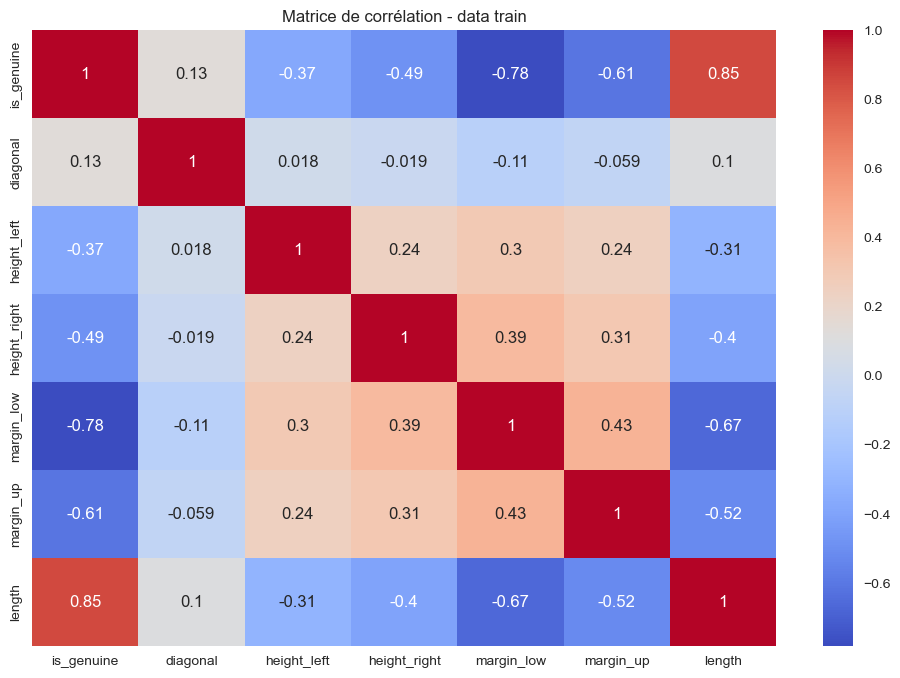

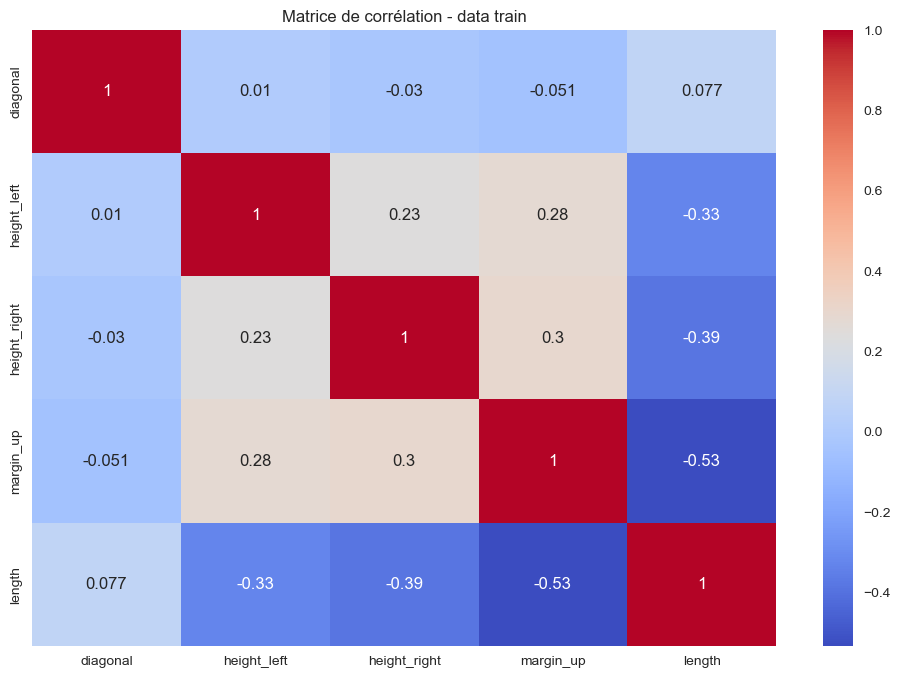

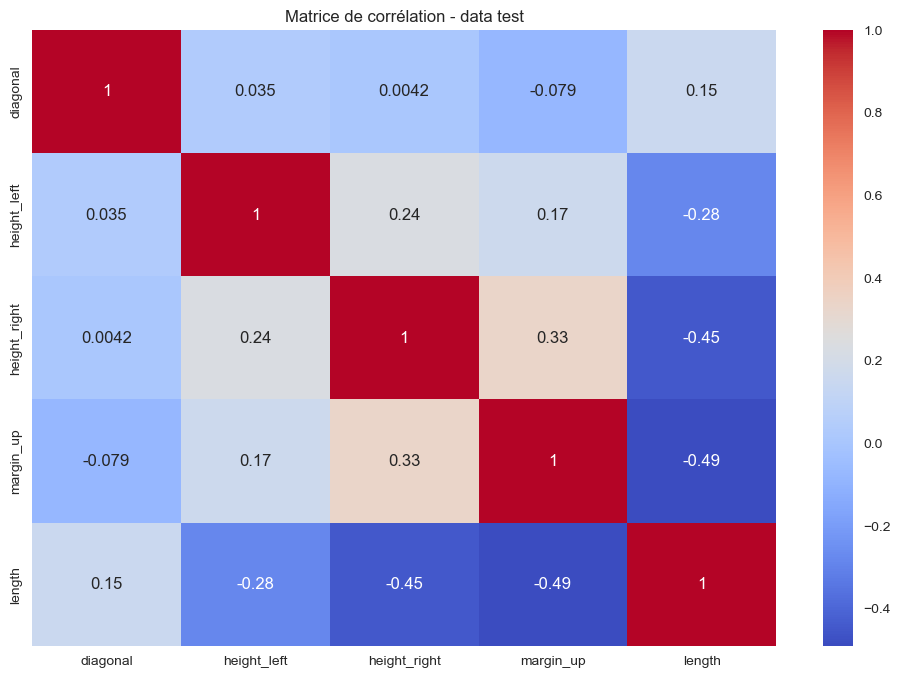

In [275]:
# Matrice de corrélation
plt.figure(figsize=(12, 8))
sns.heatmap(data_model.corr(), annot=True, cmap='coolwarm')
plt.title('Matrice de corrélation - data train')
plt.show()

# Matrice de corrélation pour les data train
plt.figure(figsize=(12, 8))
sns.heatmap(X_train.corr(), annot=True, cmap='coolwarm')
plt.title('Matrice de corrélation - data train')
plt.show()

# Matrice de corrélation pour les data test
plt.figure(figsize=(12, 8))
sns.heatmap(X_test.corr(), annot=True, cmap='coolwarm')
plt.title('Matrice de corrélation - data test')
plt.show()

# Exercice2:
### Optimiser les modèles Ridge, Lasso et ElasticNet

###
### Pour ridge

In [115]:
from sklearn.pipeline import Pipeline, make_pipeline

from sklearn import set_config

set_config(display="diagram", print_changed_only=True)

In [186]:
# définition de Pipeline de régression avec Pipeline (c'est à nous de données les noms de chaque étape du workflow)
ridge_pipe = Pipeline(steps=[("scaler", MinMaxScaler()),
                           ("regressor", linear_model.Ridge()),
                          ]
                   )
# ou via make_pipeline (la seule différence est que make_pipeline génère automatiquement des noms pour les étapes).
# reg_pipe = make_pipeline(StandardScaler(), linear_model.LinearRegression())
ridge_pipe

Pipeline(steps=[('scaler', MinMaxScaler()), ('regressor', Ridge())])

In [163]:
# plage de paramètres à tester
ridge_param_test = {'regressor__alpha': [0.1, 1, 5, 10, 100]}
# GridSearchCV pour optimisation
ridge_opti_param = GridSearchCV(ridge_pipe, ridge_param_test, cv=10, scoring="r2", return_train_score=True)
ridge_opti_param.fit(X_train, y_train)
# Afficher les meilleurs paramètres
print("Paramètre optimal pour Ridge : ", ridge_opti_param.best_params_)

Paramètre optimal pour Ridge :  {'regressor__alpha': 1}


###

### Pour lasso

In [165]:
# définition de Pipeline de régression avec Pipeline (c'est à nous de données les noms de chaque étape du workflow)
lasso_pipe = Pipeline(steps=[("scaler", MinMaxScaler()),
                           ("regressor", linear_model.Lasso()),
                          ]
                   )
# ou via make_pipeline (la seule différence est que make_pipeline génère automatiquement des noms pour les étapes).
# reg_pipe = make_pipeline(StandardScaler(), linear_model.LinearRegression())
lasso_pipe

Pipeline(steps=[('scaler', MinMaxScaler()), ('regressor', Lasso())])

In [223]:
# plage de paramètres à tester
lasso_param_test = {'regressor__alpha': [1, 5, 10, 100]}
# GridSearchCV pour optimisation
lasso_opti_param = GridSearchCV(lasso_pipe, lasso_param_test, cv=10, scoring="r2", return_train_score=True)
lasso_opti_param.fit(X_train, y_train)
# Afficher les meilleurs paramètres
print("Paramètre optimal pour Lasso : ", lasso_opti_param.best_params_)

Paramètre optimal pour Lasso :  {'regressor__alpha': 1}


###

### Pour elasticnet

In [205]:
# définition de Pipeline de régression avec Pipeline (c'est à nous de données les noms de chaque étape du workflow)
elnet_pipe = Pipeline(steps=[("scaler", MinMaxScaler()),
                           ("regressor", linear_model.ElasticNet()),
                          ]
                   )
# ou via make_pipeline (la seule différence est que make_pipeline génère automatiquement des noms pour les étapes).
# reg_pipe = make_pipeline(StandardScaler(), linear_model.LinearRegression())
elnet_pipe

Pipeline(steps=[('scaler', MinMaxScaler()), ('regressor', ElasticNet())])

In [332]:
# plage de paramètres à tester
elnet_param_test = {'regressor__alpha': [0.1, 0.5, 10], 'regressor__l1_ratio': [2, 5, 1]}
# GridSearchCV pour optimisation
elnet_opti_param = GridSearchCV(elnet_pipe, elnet_param_test, cv=10, scoring="r2", return_train_score=True)
elnet_opti_param.fit(X_train, y_train)
# Afficher les meilleurs paramètres
print("Paramètre optimal pour Elastictnet : ", elnet_opti_param.best_params_)

Paramètre optimal pour Elastictnet :  {'regressor__alpha': 0.1, 'regressor__l1_ratio': 1}


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning:


60 fits failed out of a total of 90.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\ProgramData\anaconda3\Lib\site-packages\sklearn\pipeline.py", line 473, in fit
    self._final_estimator.fi

### Etudier l'importance des variables dans chaque modèle

###

### Pour ridge

ridge_pipe.fit(X_train, y_train)
df_feature_importance_ridge = pd.DataFrame(ridge_pipe[-1].coef_, columns=["coef"], index=ridge_opti_param.feature_names_in_)
print(f"Shape: {df_feature_importance_ridge.shape}")
df_feature_importance_ridge.head()

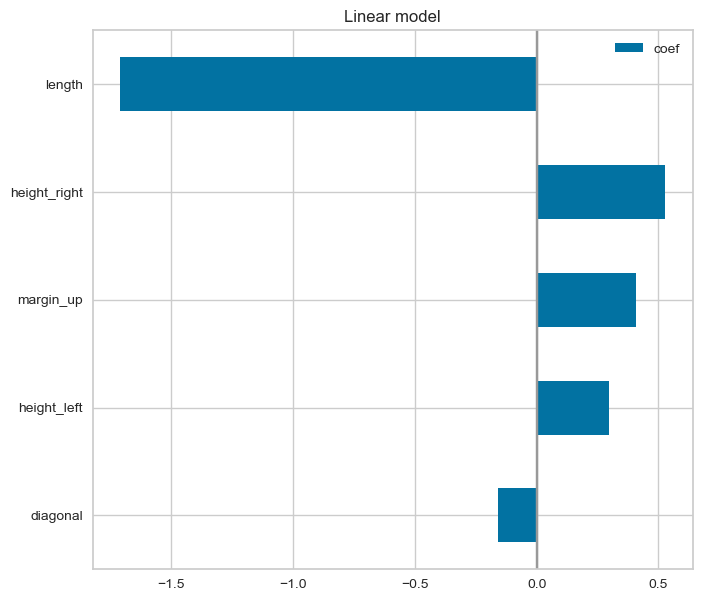

In [215]:
# top30 most important features
(df_feature_importance_ridge
 .sort_values("coef", key=lambda v: abs(v), ascending=True)
 .plot(kind="barh", figsize=(10, 7))
)
plt.title("Linear model")
plt.axvline(x=0, color='.6')
plt.subplots_adjust(left=.3);

###

### Pour lasso

In [225]:
lasso_pipe.fit(X_train, y_train)
df_feature_importance_lasso = pd.DataFrame(lasso_pipe[-1].coef_, columns=["coef"], index=lasso_opti_param.feature_names_in_)
print(f"Shape: {df_feature_importance_lasso.shape}")
df_feature_importance_lasso.head()

Shape: (5, 1)


,coef
diagonal,-0.0
height_left,0.0
height_right,0.0
margin_up,0.0
length,-0.0


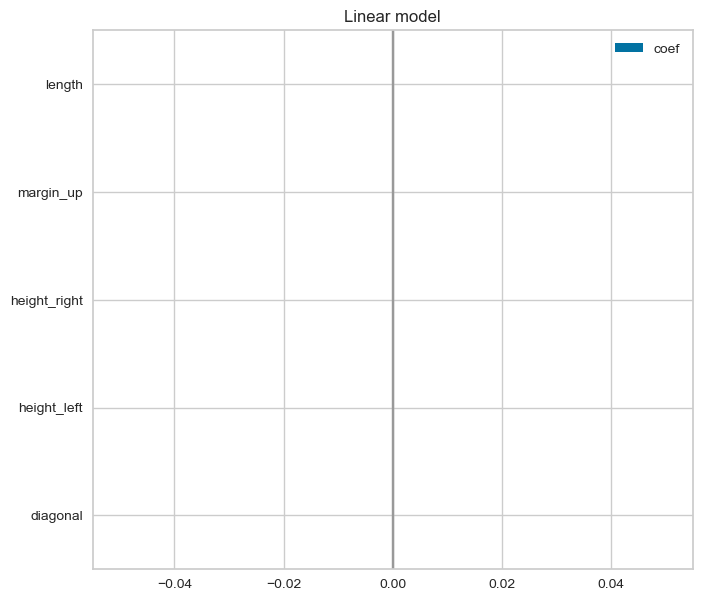

In [227]:
# top30 most important features
(df_feature_importance_lasso
 .sort_values("coef", key=lambda v: abs(v), ascending=True)
 .plot(kind="barh", figsize=(10, 7))
)
plt.title("Linear model")
plt.axvline(x=0, color='.6')
plt.subplots_adjust(left=.3);

###

### Pour Elasticnet

In [334]:
elnet_pipe.fit(X_train, y_train)
df_feature_importance_elnet = pd.DataFrame(elnet_pipe[-1].coef_, columns=["coef"], index=elnet_opti_param.feature_names_in_)
print(f"Shape: {df_feature_importance_elnet.shape}")
df_feature_importance_elnet.head()

Shape: (5, 1)


,coef
diagonal,-0.0
height_left,0.0
height_right,0.0
margin_up,0.0
length,-0.0


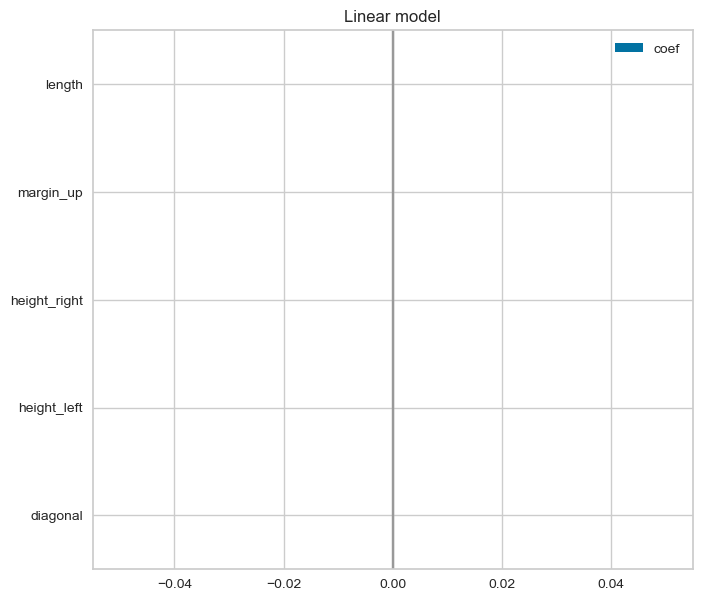

In [336]:
# top30 most important features
(df_feature_importance_elnet
 .sort_values("coef", key=lambda v: abs(v), ascending=True)
 .plot(kind="barh", figsize=(10, 7))
)
plt.title("Linear model")
plt.axvline(x=0, color='.6')
plt.subplots_adjust(left=.3);